## Построение графа взаимочастотности, где узлы — (слово, POS-tag), а рёбра отображают последовательности слов в тексте. Код заимствован из эксперимента «Graph-Based Siamese Network for Authorship Verification», где на подобных графах происходило обучение нейросетки.

Установка зависимостей + загрузка датасета (5 фанфиков для 10 случайных авторов)

In [2]:
!pip install pymorphy3
!pip install razdel

In [13]:
from google.colab import files
import networkx as nx
import os
from pymorphy3 import MorphAnalyzer
import pandas as pd
import razdel

In [ ]:
files.upload()

In [15]:
%%capture
!unzip "/content/fanfics_for_syntactic_graphs.zip" -d "/content"

In [36]:
texts_dict = {'filename': [], 'text': []}

folder_path = '/content/fanfics_for_syntactic_graphs/'
for filename in os.listdir(folder_path):
  with open(folder_path + filename, 'r', encoding='utf-8') as text_file:
    text = text_file.read()
    texts_dict['filename'].append(filename.split('.')[0])
    texts_dict['text'].append(text)

In [37]:
df = pd.DataFrame(texts_dict)
df

,filename,text
0,15855_87465,"РЕКЛАМА\n- Говорю тебе, здесь, что-то не так. ..."
1,15855_109173,Пусть горят мои стихи огнем!\nЧтоб никто не см...
2,58628_154229,"РЕКЛАМА\n— Зой, зая… А, может, не надо?..\n— К..."
3,23313_83926,-----\nЭпиграф: Постель – не повод для знакомс...
4,18704_55325,Толя сидела на крыше и вздыхала. Ночь. Звезды....
5,94_5435092,"А ночь выдалась прохладной. Горная, звёздная, ..."
6,15650_87850,"- Да пошли вы, – резко поднимаюсь из-за парты ..."
7,25628_64766,"— Главное – не разбей этого кота, – предупрежд..."
8,21482_55214,Холодный вечер. Еще один холодный вечер этой ч...
9,23313_80473,"------\nЭпиграф:\nКуда пойти, куда податься?\n..."


#1. PREPROCESSING WITH PYMORPHY

In [38]:
def tokenize(text):
  return [_.text for _ in list(razdel.tokenize(text))]

In [39]:
def get_pos(parsed_token):
  extra_tags = ('LATN', 'PNCT', 'NUMB', 'intg', 'real', 'ROMN', 'UNKN')
  if parsed_token.tag.POS is not None:
    return parsed_token.tag.POS
  for tag in extra_tags:
    if tag in parsed_token.tag:
      return tag

In [40]:
def preprocess(text):
  has_ad = False
  tokenized_text = tokenize(text)
  morph = MorphAnalyzer()
  preprocessed_text = []
  if tokenized_text[1] == "•":
    tokenized_text = tokenized_text[3:]
  elif tokenized_text[0] == "РЕКЛАМА":
    tokenized_text = tokenized_text[1:]
  for i, token in enumerate(tokenized_text):
    parsed_token = morph.parse(token)[0]
    preprocessed_text.append((parsed_token.normal_form, get_pos(parsed_token)))
  return preprocessed_text

In [41]:
df['preprocessed_text'] = df['text'].apply(preprocess)
df

,filename,text,preprocessed_text
0,15855_87465,"РЕКЛАМА\n- Говорю тебе, здесь, что-то не так. ...","[(-, PNCT), (говорить, VERB), (ты, NPRO), (,, ..."
1,15855_109173,Пусть горят мои стихи огнем!\nЧтоб никто не см...,"[(пусть, PRCL), (гореть, VERB), (мой, ADJF), (..."
2,58628_154229,"РЕКЛАМА\n— Зой, зая… А, может, не надо?..\n— К...","[(—, PNCT), (зоя, NOUN), (,, PNCT), (зая, UNKN..."
3,23313_83926,-----\nЭпиграф: Постель – не повод для знакомс...,"[(-----, PNCT), (эпиграф, NOUN), (:, PNCT), (п..."
4,18704_55325,Толя сидела на крыше и вздыхала. Ночь. Звезды....,"[(толя, NOUN), (сидеть, VERB), (на, PREP), (кр..."
5,94_5435092,"А ночь выдалась прохладной. Горная, звёздная, ...","[(а, CONJ), (ночь, NOUN), (выдаться, VERB), (п..."
6,15650_87850,"- Да пошли вы, – резко поднимаюсь из-за парты ...","[(-, PNCT), (да, PRCL), (послать, VERB), (вы, ..."
7,25628_64766,"— Главное – не разбей этого кота, – предупрежд...","[(—, PNCT), (главное, NOUN), (–, PNCT), (не, P..."
8,21482_55214,Холодный вечер. Еще один холодный вечер этой ч...,"[(холодный, ADJF), (вечер, NOUN), (., PNCT), (..."
9,23313_80473,"------\nЭпиграф:\nКуда пойти, куда податься?\n...","[(------, PNCT), (эпиграф, NOUN), (:, PNCT), (..."


# 2. BUILDING GRAPHS

In [42]:
!pip install torch_geometric

In [43]:
import networkx as nx
import time
from itertools import chain
from collections import deque, Counter
from sys import getsizeof, stderr
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from torch_geometric import utils
import torch
from tqdm import tqdm
from joblib import Parallel, delayed
import sys
from torch_geometric.utils import convert, softmax

Список POS-tags (тегов частей речи) для построения графов

In [44]:
_classes = ['NOUN', 'ADJF', 'ADJS', 'COMP', 'VERB', 'INFN', 'PRTF', 'PRTS', 'GRND', 'NUMR', 'ADVB', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ', 'LATN', 'PNCT', 'NUMB', 'intg', 'real', 'ROMN', 'UNKN']

Далее идёт код построения и визуализации графов, заимствованный из работы [«Graph-Based Siamese Network for authorship Verification»](https://www.researchgate.net/publication/357906614_Graph-Based_Siamese_Network_for_Authorship_Verification)

Класс ToGraph, который создаёт графы из текста (логика создания графа); Класс ToCoocurrence, который создаёт графы из предобработанного текста, подающегося в виде пар (слово, POS-tag)

In [45]:
class ToGraph:
    """Parent class to generate networkx graph from parsed text"""

    def __init__(self, graph_type='Graph'):
        self.graph_type = graph_type
        if graph_type == 'MultiDiGraph':
            self.G = nx.MultiDiGraph()
        elif graph_type == 'MultiGraph':
            self.G = nx.MultiGraph()
        elif graph_type == 'DiGraph':
            self.G = nx.DiGraph()
        elif graph_type == 'Graph':
            self.G = nx.Graph()
        else:
            print('invalid graph type')
            exit()

    def node_label(self, word):
        """Set the name of each node"""

        return word

    def grown_graph(self, text):
        """Add nodes and edges from parsed text"""

        pass

    def final_tune(self, remove_loops=True):
        """Optional final operation in graph"""

        if remove_loops is True:
            self.G.remove_edges_from(nx.selfloop_edges(self.G))

    def define_node_mask(self, measure=nx.closeness_centrality):
        """Used in unmasking"""

        # Get measure for all nodes
        nodes_measure = measure(self.G)
        return nodes_measure

    def show_graph(self, graph_id=None, dest_folder='graphs'):
        """Method for graphing multigraphs with graphviz.
        Saves the image as a file"""

        name = self.graph_type + '_' + str(graph_id) + '.png'
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        path = os.path.join(dest_folder,  name)
        nx.draw_networkx(self.G)
        plt.savefig(path)


class ToCoocurrence(ToGraph):
    """Coocurrence graph from parsed text"""

    def __init__(self,
                 reduce_classes=[],
                 graph_type='Graph', weigth_labels=True):
        super().__init__(graph_type)
        self.weigth_labels = weigth_labels
        self.reduce_classes = reduce_classes

    def node_label(self, token):
        if token[1] not in self.reduce_classes:
            return token
        else:
            return (('$' + str(token[1])), token[1])

    def define_edges(self, text_tag):
        """Get list of edges. Used to test formats"""

        # Coocurrence edges loop
        edges_list = []
        node_pre = self.node_label(text_tag[0])
        for token in text_tag[1:]:
            node_act = self.node_label(token)
            edges_list.append((node_pre, node_act))
            node_pre = node_act

        total = len(edges_list)
        edges = [(node_pre, node_act, (c / total))
                 for (node_pre, node_act), c in Counter(edges_list).items()]
        return edges

    def grown_from_edges(self, edges):
        """Add edges to graph. Used to test formats"""

        self.G.add_weighted_edges_from(edges)
        # self.final_tune()

    def grown_graph(self, text_tag):
        edges = self.define_edges(text_tag)
        self.grown_from_edges(edges)

    def to_sparse_raw(self):
        """Transform to scipy sparse array and node list"""

        node_names = list(self.G.nodes())
        sparse = nx.convert_matrix.to_scipy_sparse_array(self.G)
        return sparse, node_names

    def to_sparse(self, return_node_words=False):
        """Transform to scipy sparse matrix. Used to test formats"""
        node_pos = [node[1] for node in self.G.nodes()]
        sparse = nx.convert_matrix.to_scipy_sparse_array(self.G)
        if return_node_words:
            node_words = [node for node in self.G.nodes()]
            return sparse, node_pos, node_words

        else:
            return sparse, node_pos

    def to_sparse_encoded(self):
        """Transform to scipy sparse matrix with the POS categories as attributes in sparse hue as well.
        Used to test formats"""

        sparse, node_pos = self.to_sparse()
        node_attr = encode_pos(node_pos)
        return sparse, node_attr

    def to_data(self, pos_encoder='default'):
        """Transform to pytorch tensor as it would be used in torch geometric.
        Used to test formats"""

        nx_graph = self.G
        # verify graph type
        assert type(nx_graph).__name__ in ['Graph', 'DiGraph']

        # Define graph, edges weight to edge_attr
        weight = 'weight'
        data = utils.from_networkx(nx_graph)
        data_dir = dir(data)
        if weight in data_dir:
            data['edge_attr'] = data[weight]
            delattr(data, weight)

        x_names = list(nx_graph.nodes)
        data['x_names'] = x_names

        # Convert pos in node feature and node class
        x_pos = [n[1] for n in x_names]
        if pos_encoder == 'default':
            pos_encoder = OneHotEncoder(categories=[_classes])

        x_pos = np.array(x_pos).reshape(-1, 1)
        x_sparse = pos_encoder.fit_transform(x_pos)
        x = torch.from_numpy(x_sparse.toarray())
        data['x'] = x
        return data

Создаём графы из текстов датасета

In [46]:
def text_parsed_to_graph_sparse_raw(parsed, graph_type='DiGraph', graph_id=0):
  # передавать пустой список в ToCoocurrence для сохранения информации о словах
    coocurrence = ToCoocurrence(_classes, graph_type)
    coocurrence.grown_graph(parsed)
    print('----------ToGraph.show_attributes method')
    print('graph_type: ', coocurrence.graph_type)
    print('Nodes:', nx.number_of_nodes(coocurrence.G))
    print('Edges:', nx.number_of_edges(coocurrence.G))
    print('loops:', nx.number_of_selfloops(coocurrence.G))
    coocurrence.show_graph(graph_id)
    return coocurrence

После применения функции ко всем текстам рисуется общий граф для **всех** текстов (все графы выводятся на одном полотне)

----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 19
Edges: 148
loops: 11
----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 19
Edges: 165
loops: 9
----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 19
Edges: 126
loops: 9
----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 19
Edges: 153
loops: 8
----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 19
Edges: 155
loops: 9
----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 18
Edges: 108
loops: 8
----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 21
Edges: 165
loops: 10
----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 19
Edges: 155
loops: 9
----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 19
Edges: 148
loops: 8
----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 19
Edges: 152
loops: 9
----------ToGraph.show_attributes method
graph_type:  DiGraph
Nodes: 17
Edges:

,filename,text,preprocessed_text,graph
0,15855_87465,"РЕКЛАМА\n- Говорю тебе, здесь, что-то не так. ...","[(-, PNCT), (говорить, VERB), (ты, NPRO), (,, ...",<__main__.ToCoocurrence object at 0x7aae8b07b100>
1,15855_109173,Пусть горят мои стихи огнем!\nЧтоб никто не см...,"[(пусть, PRCL), (гореть, VERB), (мой, ADJF), (...",<__main__.ToCoocurrence object at 0x7aae8b078340>
2,58628_154229,"РЕКЛАМА\n— Зой, зая… А, может, не надо?..\n— К...","[(—, PNCT), (зоя, NOUN), (,, PNCT), (зая, UNKN...",<__main__.ToCoocurrence object at 0x7aae8b07a1a0>
3,23313_83926,-----\nЭпиграф: Постель – не повод для знакомс...,"[(-----, PNCT), (эпиграф, NOUN), (:, PNCT), (п...",<__main__.ToCoocurrence object at 0x7aae8e183e20>
4,18704_55325,Толя сидела на крыше и вздыхала. Ночь. Звезды....,"[(толя, NOUN), (сидеть, VERB), (на, PREP), (кр...",<__main__.ToCoocurrence object at 0x7aae8b949420>


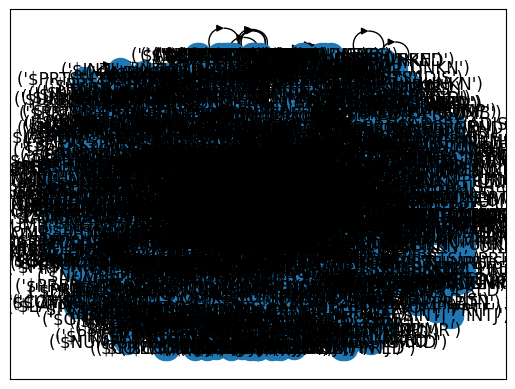

In [47]:
df['graph'] = df['preprocessed_text'].apply(text_parsed_to_graph_sparse_raw)
df.head()

Далее строю графы для текстов отдельно взятого автора. Узлы — (POS-tag, POS-tag), это можно изменить на (слово, POS-tag) путём замены строчки кода выше. Сейчас оставила так, поскольку построение графа с подобным узлом занимает много времени (где-то больше получаса для 50 текстов + полотно графа менее читаемо, по сравнению с тем, что ниже)

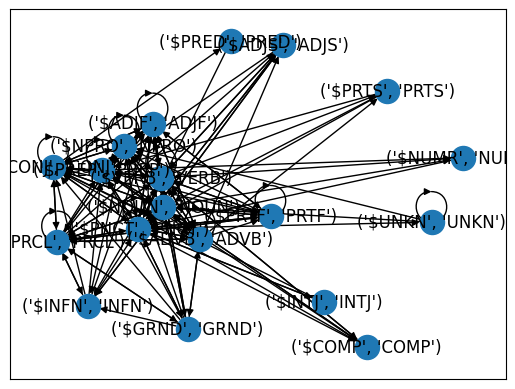

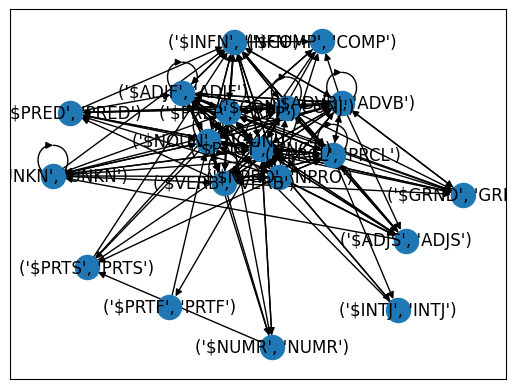

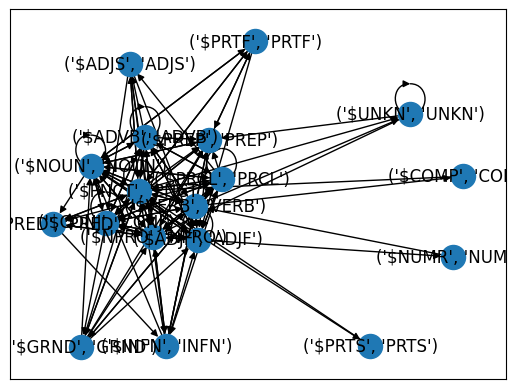

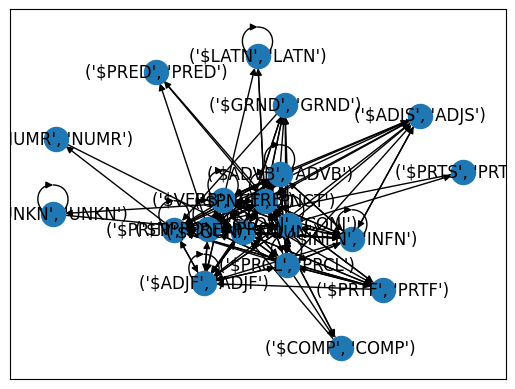

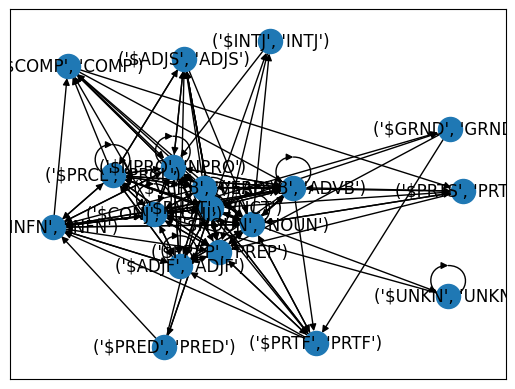

In [57]:
import matplotlib.pyplot as plt

for i, graph in enumerate(df.loc[df["filename"].str.contains("15855")]["graph"]):
  plt.figure(i)
  nx.draw_networkx(graph.G)

  #nx.draw_networkx(df["graph"][0].G)